In [23]:

# --- Set cores and seed ---
import os
N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"

# --- Import Libraries ---
import jax.numpy as jnp
import jax

print(jax.devices(), jax.device_count())

import pandas as pd
import numpy as np
import pyreadr

from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.optim import ClippedAdam
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoLowRankMultivariateNormal, AutoNormal
import numpyro.distributions as dist
import numpyro

import matplotlib.pyplot as plt

import src.utils as utils

import Data.Palluck_et_al.data_wrangle as dw



[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)] 4


In [2]:
all_schools = pyreadr.read_r('Data/Palluck_et_al/37070-0001-Data.rda')
all_schools = pd.DataFrame(all_schools['da37070.0001'])

df_cleaned = dw.clean_data(all_schools)

print(df_cleaned.shape)
print(df_cleaned.columns)

(24182, 41)
Index(['SCHID', 'SCHTREAT_NUMERIC', 'TREAT_NUMERIC', 'unique_id', 'ELIGIBLE',
       'WRISTOW2_NUMERIC', 'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7',
       'ST8', 'ST9', 'ST10', 'ST1W2', 'ST2W2', 'ST3W2', 'ST4W2', 'ST5W2',
       'ST6W2', 'ST7W2', 'ST8W2', 'ST9W2', 'ST10W2', 'BF1', 'BF2', 'BF1W2',
       'BF2W2', 'GENC', 'ETHW', 'ETHB', 'ETHH', 'ETHA', 'ETHC', 'ETHSA',
       'GAME', 'GRC_6', 'GRC_7', 'GRC_8'],
      dtype='object')


In [3]:
df_cleaned["SCHID"].unique()

array([ 1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 53., 55., 56.,
       57., 58., 59., 60.])

In [102]:
# test one school

# df_min = df_cleaned[df_cleaned['SCHID'] == 41.0]
df_min = df_cleaned[df_cleaned['SCHID'].isin([41.0,49.0, 51.0])]
# df_min = df_cleaned[df_cleaned['SCHID'] == 49.0]
print(df_min.shape)

(1459, 41)


In [105]:
n_schools = df_min["SCHID"].nunique()
# get number of students in each school
n_within_school = df_min.groupby("SCHID").size().values

offsets = jnp.concatenate([jnp.array([0]), jnp.cumsum(jnp.array(n_within_school))[:-1]]) 

total_n = df_min.shape[0]

total_edges = n_within_school * (n_within_school - 1) / 2

print(n_schools, n_within_school, offsets, total_n, total_edges, total_edges.sum())

3 [503 409 547] [  0 503 912] 1459 [126253.  83436. 149331.] 359020.0


In [106]:
# jnp.concatenate(jnp.array([0]),jnp.cumsum(jnp.array(n_within_school))[:-1]) 
df_min["unique_id"]

16839    41001
16840    41002
16841    41003
16842    41004
16843    41005
         ...  
20526    51555
20527    51556
20528    51558
20529    51559
20530    51560
Name: unique_id, Length: 1459, dtype: int32

In [107]:
jnp.concatenate([jnp.array([]), jnp.array([1,2,3])])

Array([1., 2., 3.], dtype=float32)

In [109]:
# nets by schools 
st_triu = jnp.array([])
stw2_triu = jnp.array([])
bf_triu = jnp.array([])
bfw2_triu = jnp.array([])



for s_id in df_min["SCHID"].unique():
    df_s = df_min[df_min["SCHID"] == s_id]
    triu_idx = np.triu_indices(df_s.shape[0], 1)
    
    st_net = dw.network_by_school(df_s, dw.ST_COLS, False)
    st_triu = jnp.concatenate([st_triu, jnp.array(st_net[triu_idx], dtype=jnp.float32)])

    stw2_net = dw.network_by_school(df_s, dw.ST_W2_COLS, False)
    stw2_triu = jnp.concatenate([stw2_triu, jnp.array(stw2_net[triu_idx], dtype=jnp.float32)])

    bf_net = dw.network_by_school(df_s, dw.BF_COLS, False)
    bf_triu = jnp.concatenate([bf_triu, jnp.array(bf_net[triu_idx], dtype=jnp.float32)])

    bfw2_net = dw.network_by_school(df_s, dw.BF_W2_COLS, False)
    bfw2_triu = jnp.concatenate([bfw2_triu, jnp.array(bfw2_net[triu_idx], dtype=jnp.float32)])
    



# st_net = dw.network_by_school(df_min, dw.ST_COLS, False)
# st_net_triu = jnp.array(st_net[triu_idx], dtype=jnp.float32)

# # ST_w2 net 

# stw2_net = dw.network_by_school(df_min, dw.ST_W2_COLS, False)
# stw2_net_triu = jnp.array(stw2_net[triu_idx], dtype=jnp.float32)

# # BF net

# bf_net = dw.network_by_school(df_min, dw.BF_COLS, False)
# bf_net_triu = jnp.array(bf_net[triu_idx], dtype=jnp.float32)

# # BF_w2 net

# bfw2_net = dw.network_by_school(df_min, dw.BF_W2_COLS, False)
# bfw2_net_triu = jnp.array(bfw2_net[triu_idx], dtype=jnp.float32)

# print(st_net_triu.shape, stw2_net_triu.shape, bf_net_triu.shape, bfw2_net_triu.shape)

print(st_triu.shape, stw2_triu.shape, bf_triu.shape, bfw2_triu.shape)

(359020,) (359020,) (359020,) (359020,)


In [6]:
NODE_COV = ["GENC", "ETHW", "ETHB", "ETHH", "ETHA", "ETHC", "ETHSA", "GAME", "GRC_6", "GRC_7", "GRC_8"]
df_min_node_cov = jnp.array(df_min[NODE_COV])
print(df_min_node_cov.shape)


(409, 11)


In [34]:
%%time 
# df_min_net_cov = cov_for_net(df_min, NODE_COV)
df_min_net_cov = dw.cov_for_net(df_min, dw.COV_FOR_NETWORK)

print(df_min_net_cov.shape, df_min_net_cov.dtype, type(df_min_net_cov))

(126253, 5) float32 <class 'jaxlib.xla_extension.ArrayImpl'>
CPU times: total: 1.22 s
Wall time: 1.28 s


In [ ]:
PRIOR_SCALE = jnp.sqrt(5.0)

def networks_marginalized_model(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We embed it as mixture model of A edges

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
    """
    # --- Priors ---

    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
    # with numpyro.plate("theta_plate", n_cols):
        # theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE))
    
    # with numpyro.plate("gamma_plate", n_cols + 1):
        # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE))

        # P(A*_ij=1)
    # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2*n_cols]))
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2]))

        # P(A*_ij=1)
    # star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_diff)
    star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_norm)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[1:])
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[:n_cols])
    obs_probs_k0 = jax.nn.sigmoid(gamma[0])
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    # obs_probs_k1 = jax.nn.sigmoid(gamma[0] + data["cov"] @ gamma[1:])
    # obs_probs_k1 = jax.nn.sigmoid(data["cov"]  @ gamma[n_cols:])
    obs_probs_k1 = jax.nn.sigmoid(gamma[1])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # marginalized probs P(A_ij=1)
    mixed_probs = star_probs * obs_probs_k1 + (1 - star_probs) * obs_probs_k0

    with numpyro.plate("edges", data["STW2_triu"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # save posterior A_star probs
    # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
    #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
    # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)

    # numerator aka p_1
    numerator = jnp.where(
        data["STW2_triu"] == 1.0, star_probs * obs_probs_k1, star_probs * (1 - obs_probs_k1)
    )
    # denominator aka p_1 + p_0
    denominator = numerator + jnp.where(
        data["STW2_triu"] == 1.0,
        (1 - star_probs) * obs_probs_k0,
        (1 - star_probs) * (1 - obs_probs_k0),
    )

    numpyro.deterministic("triu_star_probs", numerator / denominator)



In [ ]:

def networks_marginalized_multi_school(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We embed it as mixture model of A edges

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
    """
    # --- Global parameters ---

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
  
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2]))

     # 2. School-specific random intercepts -----------------------------------

    # We'll allow each school s to have an intercept alpha_s
    #   alpha_s ~ Normal(0, prior_scale)   or something hierarchical if you prefer
    n_schools = data["n_schools"]
    alpha = numpyro.sample("alpha", dist.Normal(0, PRIOR_SCALE).expand([n_schools]))

    
    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
    # with numpyro.plate("theta_plate", n_cols):
        # theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE))
    
    # with numpyro.plate("gamma_plate", n_cols + 1):
        # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE))

        # P(A*_ij=1)
    # gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2*n_cols]))
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([2]))

        # P(A*_ij=1)
    # star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_diff)
    star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_norm)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[1:])
    # obs_probs_k0 = jax.nn.sigmoid(data["cov"] @ gamma[:n_cols])
    obs_probs_k0 = jax.nn.sigmoid(gamma[0])
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    # obs_probs_k1 = jax.nn.sigmoid(gamma[0] + data["cov"] @ gamma[1:])
    # obs_probs_k1 = jax.nn.sigmoid(data["cov"]  @ gamma[n_cols:])
    obs_probs_k1 = jax.nn.sigmoid(gamma[1])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # marginalized probs P(A_ij=1)
    mixed_probs = star_probs * obs_probs_k1 + (1 - star_probs) * obs_probs_k0

    with numpyro.plate("edges", data["STW2_triu"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(mixed_probs), obs=data["STW2_triu"])

    # save posterior A_star probs
    # let  p_1 = P(A*_ij=1)*P(A_ij| A*_ij=1)
    #      p_0 = P(A*_ij=0 )*P(A_ij| A*_ij=0)
    # then posterior probs P(A*_ij | A, \theta,\ gamma) = p_1 / (p_1 + p_0)

    # numerator aka p_1
    numerator = jnp.where(
        data["STW2_triu"] == 1.0, star_probs * obs_probs_k1, star_probs * (1 - obs_probs_k1)
    )
    # denominator aka p_1 + p_0
    denominator = numerator + jnp.where(
        data["STW2_triu"] == 1.0,
        (1 - star_probs) * obs_probs_k0,
        (1 - star_probs) * (1 - obs_probs_k0),
    )

    numpyro.deterministic("triu_star_probs", numerator / denominator)



In [9]:

def networks_marginalized_model_rep(data):
    """
    Model for network only models with marginalized A*
    Used in cut-posterior sampling

    We have repeated proxy measures A^r, A

    We embed it as mixture model of (A^r, A) edges (4 categories)

    Args:
      data: an object with attributes:
           - x_diff: a 1D array (one per edge) of differences in covariates,
           - x2_or: a 1D array of indicators (one per edge) for whether x2_i + x2_j = 1,
           - triu_obs: a 1D array of observed edge indicators (binary; one per edge).
           - triu_obs_rep: a 1D array of repeated observed edge indicators (binary; one per edge).
    """

    # latent positions
    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    # priors
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([2]))
    gamma = numpyro.sample("gamma", dist.Normal(0, PRIOR_SCALE).expand([7]))

    # P(A*_ij=1)
    star_probs = jax.nn.sigmoid(theta[0] + theta[1] * data.x2_or)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 1)
    obs_probs_k1 = jax.nn.sigmoid(gamma[0])
    obs_probs_k1 = jnp.clip(obs_probs_k1, 1e-6, 1 - 1e-6)

    # P(A_ij = 1 | A*_ij = 0)
    obs_probs_k0 = jax.nn.sigmoid(gamma[1] + gamma[2] * data.x_diff)
    obs_probs_k0 = jnp.clip(obs_probs_k0, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=1, A_ij)
    obs_rep_probs_k1 = jax.nn.sigmoid(gamma[3] + gamma[4] * data.triu_obs)
    obs_rep_probs_k1 = jnp.clip(obs_rep_probs_k1, 1e-6, 1 - 1e-6)

    # P(A^r_ij=1 | A*_ij=0, A_ij)
    obs_rep_probs_k0 = jax.nn.sigmoid(gamma[5] + gamma[6] * data.triu_obs)
    obs_rep_probs_k0 = jnp.clip(obs_rep_probs_k0, 1e-6, 1 - 1e-6)

    # compute marginalize probs of (A^_ij=r, A_ij=a), a,r \in {0,1}
    # represent as categorical $C_ij = 2 A_ij + A^r_ij \in {0,1,2,3}
    # Given A*_ij=1
    # p(A_ij=r, A^r_ij=a | A*_ij=1)*P(A*_ij=1)
    pj_star1_cat0 = star_probs * (1 - obs_probs_k1) * (1 - obs_rep_probs_k1)
    pj_star1_cat1 = star_probs * (1 - obs_probs_k1) * obs_rep_probs_k1
    pj_star1_cat2 = star_probs * obs_probs_k1 * (1 - obs_rep_probs_k1)
    pj_star1_cat3 = star_probs * obs_probs_k1 * obs_rep_probs_k1

    # Given A*_ij=0
    # p(A_ij=r, A^r_ij=a | A*_ij=0)*P(A*_ij=0)
    pj_star0_cat0 = (1 - star_probs) * (1 - obs_probs_k0) * (1 - obs_rep_probs_k0)
    pj_star0_cat1 = (1 - star_probs) * (1 - obs_probs_k0) * obs_rep_probs_k0
    pj_star0_cat2 = (1 - star_probs) * obs_probs_k0 * (1 - obs_rep_probs_k0)
    pj_star0_cat3 = (1 - star_probs) * obs_probs_k0 * obs_rep_probs_k0

    # marginalized probs P(C_ij=c) = \sum_{0,1} p(A_ij=r, A^r_ij=a | A*_ij=k)*P(A*_ij=k)
    p_cat0 = pj_star1_cat0 + pj_star0_cat0
    p_cat1 = pj_star1_cat1 + pj_star0_cat1
    p_cat2 = pj_star1_cat2 + pj_star0_cat2
    p_cat3 = pj_star1_cat3 + pj_star0_cat3

    probs = jnp.stack([p_cat0, p_cat1, p_cat2, p_cat3], axis=-1)
    probs = probs / jnp.sum(probs, axis=-1, keepdims=True)

    # observed categorical data
    obs_cat = jnp.astype(2 * data.triu_obs + data.triu_obs_rep, jnp.int32)

    with numpyro.plate("edges", data.triu_obs.shape[0]):
        numpyro.sample("obs_joint", dist.Categorical(probs=probs), obs=obs_cat)

    # --- Compute the posterior probability of A*_ij=1 given the joint observation ---
    # Select the appropriate terms based on the observed category
    # p_1 = p(C_ij = c | A*_ij = 1)p(A*_ij = 1)
    numerator = jnp.where(
        obs_cat == 0,
        pj_star1_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star1_cat1,
            jnp.where(obs_cat == 2, pj_star1_cat2, pj_star1_cat3),
        ),
    )

    # p_0 = p(C_ij = c | A*_ij = 0)p(A*_ij = 0)
    # denom is p_0 + p_1
    denominator = numerator + jnp.where(
        obs_cat == 0,
        pj_star0_cat0,
        jnp.where(
            obs_cat == 1,
            pj_star0_cat1,
            jnp.where(obs_cat == 2, pj_star0_cat2, pj_star0_cat3),
        ),
    )
    # p_1 / (p_0 + p_1)
    posterior_star = numerator / denominator

    # Save the posterior probabilities for A* (for example, on the upper triangle of the network)
    numpyro.deterministic("triu_star_probs", posterior_star)



In [10]:
data_st = {"STW2_triu": stw2_net_triu,
            "cov": df_min_net_cov,
            "ST_triu" : st_net_triu,
            "BF_triu" : bf_net_triu,
            "BFW2_triu" : bfw2_net_triu,
            "n" : df_min.shape[0]}

In [11]:
def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")



print("ST vs ST_w2")
binary_contingency_table(st_net_triu, stw2_net_triu)
print("ST vs BF")
binary_contingency_table(st_net_triu, bf_net_triu)
print("ST vs BF_w2")
binary_contingency_table(st_net_triu, bfw2_net_triu)
print("BF vs BF_w2")
binary_contingency_table(bf_net_triu, bfw2_net_triu)

ST vs ST_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 80303 | 1458 |
   1    | 1585 |  90 |
ST vs BF
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 81433 | 328 |
   1    | 1619 |  56 |
ST vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 81481 | 280 |
   1    | 1634 |  41 |
BF vs BF_w2
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 82771 | 281 |
   1    | 344 |  40 |


In [12]:
print(data_st["STW2_triu"].shape, data_st["cov"].shape)

(83436,) (83436, 5)


In [53]:
data_st["ST_triu"].sum(), data_st["STW2_triu"].sum(), data_st["BF_triu"].sum(), data_st["BFW2_triu"].sum()

(Array(1675., dtype=float32),
 Array(1548., dtype=float32),
 Array(384., dtype=float32),
 Array(321., dtype=float32))

In [42]:
init_vals = {
    "theta": jnp.zeros(data_st["cov"].shape[1]),
    # "gamma": jnp.zeros(data_st["cov"].shape[1] + 1),
    # "gamma": jnp.zeros(2*data_st["cov"].shape[1]),
    "gamma": jnp.zeros(2),
}

guide = AutoMultivariateNormal(networks_marginalized_model)

svi = SVI(
    model=networks_marginalized_model,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(0)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=10000,
                    progress_bar=True,
                    data=data_st,
                    init_params=init_vals)
map_params = guide.median(svi_result.params)

print(map_params)

100%|██████████| 10000/10000 [01:26<00:00, 115.40it/s, init loss: 137910.4688, avg. loss [9501-10000]: 7727.1487]


{'u': Array([-4.22202758e-02, -1.02847759e-02,  1.94148105e-02, -1.27057940e-01,
        1.38943375e-03,  1.03907976e-02, -1.28388461e-02,  1.54916883e-01,
        1.87343918e-03, -1.10749871e-01, -2.15215459e-02,  2.30540778e-03,
       -2.43938770e-02,  1.31882904e-02,  1.98646113e-02, -4.77152382e-04,
        1.74012110e-02, -4.31632437e-02,  7.91301206e-03,  7.26027088e-03,
        4.94199954e-02, -1.25859724e-03, -2.70339511e-02, -1.88900088e-03,
        1.88664682e-02, -8.74431804e-02, -8.36301446e-02, -9.51837674e-02,
        4.63346718e-03,  2.72600725e-03,  5.50348423e-02,  7.16266781e-02,
        9.45109688e-03, -1.65592790e-01, -2.02729926e-03,  8.64937494e-04,
       -5.80800232e-03, -1.48800448e-01, -1.95424701e-03, -9.35102813e-04,
        9.46339369e-02, -3.74162868e-02, -1.21319406e-02, -6.93107629e-03,
        1.99563652e-02,  7.33145177e-02,  1.39424354e-01,  5.31280972e-03,
       -1.60776317e-01,  3.55696529e-02,  3.84073816e-02,  3.42075117e-02,
        1.70762599e

In [ ]:

rng_key, _ = jax.random.split(rng_key)
preds = Predictive(
    model=networks_marginalized_model,
    guide=guide,
    params=svi_result.params,
    num_samples=1,
)(rng_key, data_st)

triu_star_probs = preds["triu_star_probs"][0]
print(triu_star_probs.shape)

(83436,)


(array([29334., 17836., 10430.,  6002.,  4814.,  3484.,  2455.,  1850.,
         1439.,  1260.,  1132.,   849.,   384.,   384.,   338.,   334.,
          310.,   282.,   269.,   250.]),
 array([9.10657218e-06, 4.41654678e-03, 8.82398710e-03, 1.32314274e-02,
        1.76388677e-02, 2.20463090e-02, 2.64537483e-02, 3.08611896e-02,
        3.52686308e-02, 3.96760702e-02, 4.40835096e-02, 4.84909527e-02,
        5.28983921e-02, 5.73058315e-02, 6.17132708e-02, 6.61207139e-02,
        7.05281496e-02, 7.49355927e-02, 7.93430358e-02, 8.37504715e-02,
        8.81579146e-02]),
 <BarContainer object of 20 artists>)

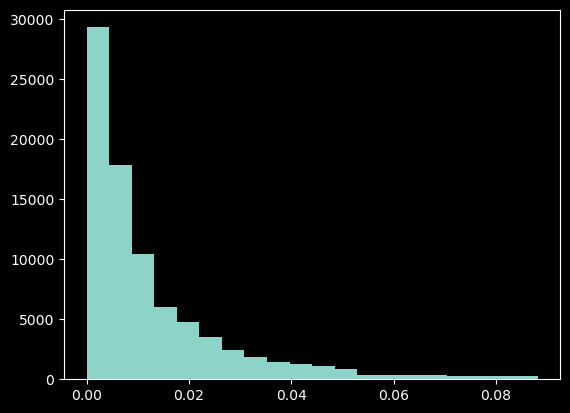

In [ ]:
plt.hist(triu_star_probs, bins=20)

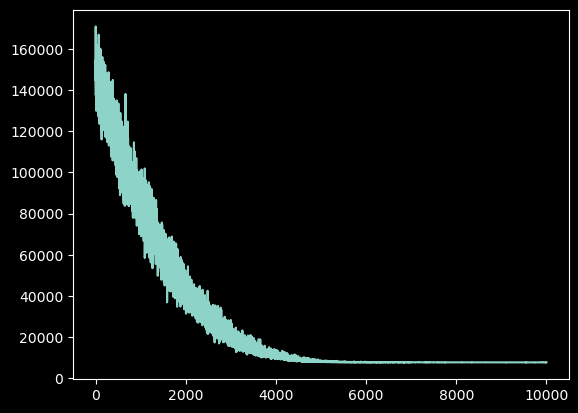

In [45]:
plt.plot(svi_result.losses)

In [46]:
from src.MWG_sampler import sample_posterior_triu_star

rng_key, _ = jax.random.split(rng_key)
post_triu = sample_posterior_triu_star(rng_key, triu_star_probs, 3000)
print(post_triu.shape)

(3000, 83436)


In [35]:
N = df_min.shape[0]

@jax.jit
def triu_to_mat(triu):
    mat = jnp.zeros((N, N))
    mat = mat.at[np.triu_indices(n=N, k=1)].set(triu)
    return mat + mat.T

@jax.jit
def compute_deg(triu):
    mat = triu_to_mat(triu)
    return jnp.sum(mat, axis=1)

vmap_deg = jax.vmap(compute_deg)



In [ ]:
true_deg = jnp.sum(st_net, axis=1)
stw2_deg = jnp.sum(stw2_net, axis=1)
bf_deg = jnp.sum(bf_net, axis=1)

post_deg = vmap_deg(post_triu)



print(post_deg.shape)


# plt.scatter(true_deg, stw2_deg)


(3000, 409)


cor ST and ST w2 0.24244009
cor ST and Post -0.05010764
cor ST and BF 0.26703674


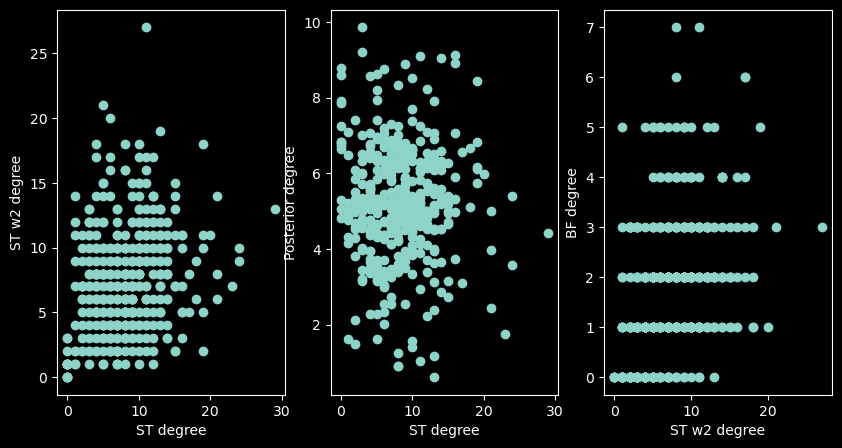

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].scatter(true_deg, stw2_deg)
axs[0].set_xlabel("ST degree")
axs[0].set_ylabel("ST w2 degree")

axs[1].scatter(true_deg, post_deg.mean(axis=0))
axs[1].set_xlabel("ST degree")
axs[1].set_ylabel("Posterior degree")

axs[2].scatter(stw2_deg, bf_deg)
axs[2].set_xlabel("ST w2 degree")
axs[2].set_ylabel("BF degree")

print("cor ST and ST w2", jnp.corrcoef(true_deg, stw2_deg)[0, 1])
print("cor ST and Post", jnp.corrcoef(true_deg, post_deg.mean(axis=0))[0, 1])
print("cor ST and BF", jnp.corrcoef(true_deg, bf_deg)[0, 1])

In [ ]:
# TODO: keep tinkering. options:
# 1. Run models with known st_triu values and perform posterior predictive checks for model fit
# 2. Run model with combined st_w2 and bf proxy networks -- think about these models form and prior p(ST) model 

In [36]:

def prior_model(data):
    with numpyro.plate("latent_u", data["n"]):
        u = numpyro.sample("u", dist.Normal(0, 1))
        # u = numpyro.sample("u", dist.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))

    idx = np.triu_indices(n=data["n"], k=1)
    u_diff = u[idx[0]] - u[idx[1]]
    u_norm = jnp.abs(u_diff)

    n_cols = data["cov"].shape[1]
    theta = numpyro.sample("theta", dist.Normal(0, PRIOR_SCALE).expand([n_cols]))
   
        # P(A*_ij=1)
    # star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_diff)
    star_probs = jax.nn.sigmoid(data["cov"] @ theta - u_norm)
    star_probs = jnp.clip(star_probs, 1e-6, 1 - 1e-6)

    with numpyro.plate("edges", data["cov"].shape[0]):
        numpyro.sample("obs", dist.BernoulliProbs(star_probs), obs=data["ST_triu"])


# run model with svi 

data_st_prior = {"ST_triu": st_net_triu,
            "cov": df_min_net_cov,
            "n" : df_min.shape[0]}

init_vals = {
    "theta": jnp.zeros(data_st_prior["cov"].shape[1]),
}

# guide = AutoMultivariateNormal(prior_model)
# guide = AutoLowRankMultivariateNormal(prior_model)
guide = AutoNormal(prior_model)

svi = SVI(
    model=prior_model,
    guide=guide,
    optim=ClippedAdam(0.0005),
    loss=Trace_ELBO(),
)

rng_key = jax.random.PRNGKey(5)
rng_key, _ = jax.random.split(rng_key)

svi_result = svi.run(rng_key=rng_key,
                    num_steps=10000,
                    progress_bar=True,
                    data=data_st_prior,
                    init_params=init_vals)

print(svi_result.params)


100%|██████████| 10000/10000 [00:41<00:00, 240.17it/s, init loss: 63750.4883, avg. loss [9501-10000]: 10180.0634]


{'theta_auto_loc': Array([-3.4695828e+00,  2.0042977e-01, -1.6675236e-02,  1.9515734e-03,
        4.4946852e-01], dtype=float32), 'theta_auto_scale': Array([0.031184  , 0.03695186, 0.04914178, 0.03640843, 0.04848412],      dtype=float32), 'u_auto_loc': Array([-8.55326414e-01, -6.91663742e-01, -7.78363645e-01, -3.87680799e-01,
       -9.55013514e-01, -1.15252268e+00, -9.85370755e-01, -1.45421815e+00,
       -1.15428591e+00, -1.23788798e+00, -1.44665885e+00, -1.23459208e+00,
        9.25605774e-01, -7.21631706e-01, -6.39822245e-01, -5.97121775e-01,
       -2.07615107e-01, -4.60302562e-01, -6.51606679e-01, -3.67773086e-01,
        8.44940022e-02, -3.11440110e-01, -3.71619105e-01, -1.69964209e-01,
        1.58955306e-01, -4.87818033e-01, -7.03590930e-01, -9.58887577e-01,
       -4.85452741e-01, -7.31882513e-01, -6.15555704e-01, -6.37028456e-01,
       -3.73188347e-01, -5.47956765e-01,  7.98394501e-01, -1.66611776e-01,
       -1.01175714e+00, -3.65844786e-01, -4.95705187e-01, -5.61826766e-0

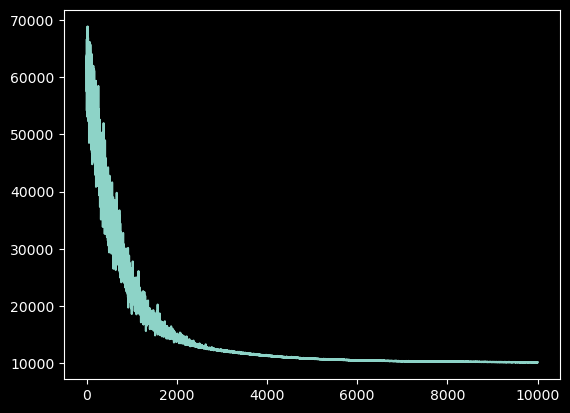

In [37]:
plt.plot(svi_result.losses)

In [38]:

data_pred = {
    "ST_triu": None,
    "cov": df_min_net_cov,
    "n" : df_min.shape[0]
}

rng_key, _ = jax.random.split(rng_key)
preds_st = Predictive(
    model=prior_model,
    guide=guide,
    params=svi_result.params,
    num_samples=3000,
)(rng_key, data_pred)["obs"]

print(preds_st.shape)

(3000, 126253)


cor ST and Post 0.69677037


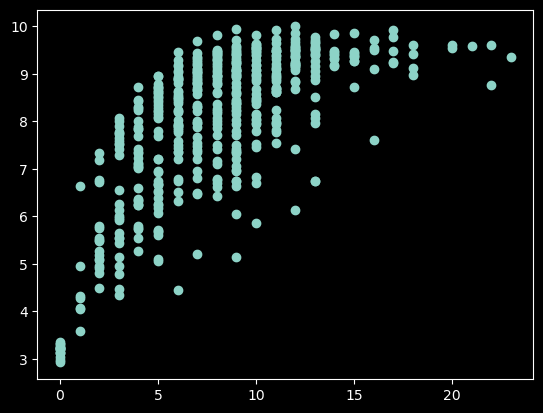

In [39]:
vmap_pred_deg = vmap_deg(preds_st)
true_deg = jnp.sum(st_net, axis=1)

plt.scatter(true_deg, vmap_pred_deg.mean(axis=0))

print("cor ST and Post", jnp.corrcoef(true_deg, vmap_pred_deg.mean(axis=0))[0, 1])